# **Model Training & Evaluation**

## Importing Credentials, Libraries & Frameworks

In [2]:
import sagemaker
import boto3
import pandas as pd
from sagemaker.tensorflow import TensorFlow

from dotenv import load_dotenv
import os

# AWS Credentials
load_dotenv()
ROLE = os.getenv("SAGEMAKER_ROLE")
ROLE_NAME = ROLE.split('/')[-1]  # Extract just the role name from the ARN

REGION = os.getenv("AWS_REGION")
BUCKET_NAME = os.getenv("BUCKET_NAME")
FILE_KEY = os.getenv("INPUT_DATA_KEY")

# AWS Session Configuration
BOTO_SESSION = boto3.Session(region_name=REGION)
SAGEMAKER_SESSION = sagemaker.Session(boto_session=BOTO_SESSION)

# Attach AdministratorAccess policy to your existing IAM Role
iam_client = boto3.client('iam')
iam_client.attach_role_policy(
    RoleName=ROLE_NAME,
    PolicyArn="arn:aws:iam::aws:policy/AdministratorAccess"
)
print(f"Attached AdministratorAccess policy to role: {ROLE}")

# Input Data Path
input_data_s3_uri = f"s3://{BUCKET_NAME}/{FILE_KEY}"

[04/24/25 22:46:49] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=743184;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=30263;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\botocore\credentials.py#1352\1352]8;;\

Attached AdministratorAccess policy to role: arn:aws:iam::211125439249:role/service-role/AmazonSageMaker-ExecutionRole-20250314T153928


## Fetch Dataset from S3

In [ ]:
if not os.path.exists("train.py"):
    print("Error: train.py not found in the current directory")
else:
    print("Found train.py in the current directory")
    # Upload train.py to S3 to ensure latest version is used
    CODE_PREFIX = "code"
    S3_CODE_PATH = SAGEMAKER_SESSION.upload_data("train.py", bucket=BUCKET_NAME, key_prefix=CODE_PREFIX)
    print(f"Uploaded train.py to {S3_CODE_PATH}")

# Verify that the S3 data file exists
try:
    s3_client = boto3.client('s3', region_name=REGION)
    s3_client.head_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
    print(f"Verified that s3://{BUCKET_NAME}/{FILE_KEY} exists")
except Exception as e:
    print(f"Warning: Error verifying S3 file: {e}")

Found train.py in the current directory
Uploaded train.py to s3://blue-blood-data/code/train.py
Verified that s3://blue-blood-data/blue-blood-synthetic-final.csv exists


In [4]:
# Initialize S3 
s3 = boto3.client("s3")
obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)

# Read CSV into pandas
df = pd.read_csv(obj['Body'])

# Get current DF columns and head
print(df.columns)
print(df.head())

Index(['prescription_dose_val_rx', 'prescription_dose_unit_rx', 'pre_ph',
       'pre_pco2', 'pre_po2', 'pre_bicarbonate', 'pre_baseexcess',
       'pre_totalco2', 'pre_hematocrit', 'pre_hemoglobin',
       ...
       'P118', 'P119', 'P120', 'P121', 'P122', 'P123', 'P124', 'P125', 'P126',
       'P127'],
      dtype='object', length=180)
   prescription_dose_val_rx  prescription_dose_unit_rx    pre_ph  pre_pco2  \
0                  0.015912                         10  0.594248  0.527314   
1                 -0.019336                          6  0.708165 -0.050647   
2                  0.011186                          8  0.587773  0.401715   
3                 -1.193432                         10  0.456588  0.514074   
4                 -0.013073                         10  0.646255  0.547561   

    pre_po2  pre_bicarbonate  pre_baseexcess  pre_totalco2  pre_hematocrit  \
0  0.142489        -1.000842       -0.879999      0.532785       -0.997184   
1 -0.051054        -1.000892       

## Hyperparameter Tuning Configuration

In [ ]:
# Define hyperparameters for testing

# epochs_list = [75, 150]
# lstm_units_list = [64, 128]
# learning_rates = [0.0001, 0.0005, 0.001] 
# dropout_rates = [0.1, 0.25, 0.35]

epochs_list = [75]
lstm_units_list = [64]
learning_rates = [0.0005]
dropout_rates = [0.1]

print(f"Starting hyperparameter testing")

# test all combinations of hyperparameters
for epochs in epochs_list:
    for learning_rate in learning_rates:
        for lstm_units in lstm_units_list:
            for dropout_rate in dropout_rates:
                # Create a unique job name based on parameters
                job_name = f"BB-{epochs}Epochs-{learning_rate}LearningRate-{lstm_units}LSTM_Units-{dropout_rate}DropoutRate"
                job_name = job_name.replace('.', 'd')  # Replace dots with 'd' for valid job name
                print(f"\nStarting job: {job_name}")

                # Create the TensorFlow estimator with this set of hyperparameters
                estimator = TensorFlow(
                    entry_point='train.py',
                    role=ROLE,
                    instance_count=1,
                    instance_type='ml.m5.4xlarge',
                    framework_version='2.9',
                    py_version='py39',
                    sagemaker_session=SAGEMAKER_SESSION,
                    hyperparameters={
                        'epochs': epochs,
                        'learning_rate': learning_rate,
                        'lstm_units': lstm_units,
                        'dropout_rate': dropout_rate,
                        'job_name': job_name
                    },
                )

                # Start training job
                estimator.fit({'train': input_data_s3_uri})

Starting hyperparameter testing

Starting job: BB-75Epochs-0d0005LearningRate-64LSTM_Units-0d1DropoutRate


[04/22/25 22:38:47] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=325446;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\telemetry\telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=948065;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\telemetry\telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=818067;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=347698;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[04/22/25 22:38:48] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=937351;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=669164;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=589951;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=76575;file://c:\Users\advay\anaconda3\envs\bb_dev\lib\site-packages\sagemaker\session.py#1042\1042]8;;\
                             tensorflow-training-2025-04-23-03-38-48-127                                           

2025-04-23 03:38:50 Starting - Starting the training job...
2025-04-23 03:39:24 Downloading - Downloading input data...
2025-04-23 03:39:40 Downloading - Downloading the training image......
2025-04-23 03:40:36 Training - Training image download completed. Training in progress...2025-04-23 03:41:02.633270: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2025-04-23 03:41:02.633420: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2025-04-23 03:41:02.659050: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2025-04-23 03:41:04,620 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2025-04-23 03:41:04,631 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-04-23 03:41:04,9

## Model Performance Evaluation 

### Evaluating: BB-75Epochs-0d0001LearningRate-128LSTM_Units-0d1DropoutRate ###


## **📈 BB-75Epochs-0d0001LearningRate-128LSTM_Units-0d1DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 128
- **Dropout Rate** : 0.1
- **Learning Rate** : 0.0001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029923966
- **Root Mean Squared Error (RMSE)**  : 0.172985450
- **Mean Absolute Error (MAE)**       : 0.041192550

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155603716
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394466368
- **Weighted Mean Absolute Error (MAE)**       : 0.213002334

    

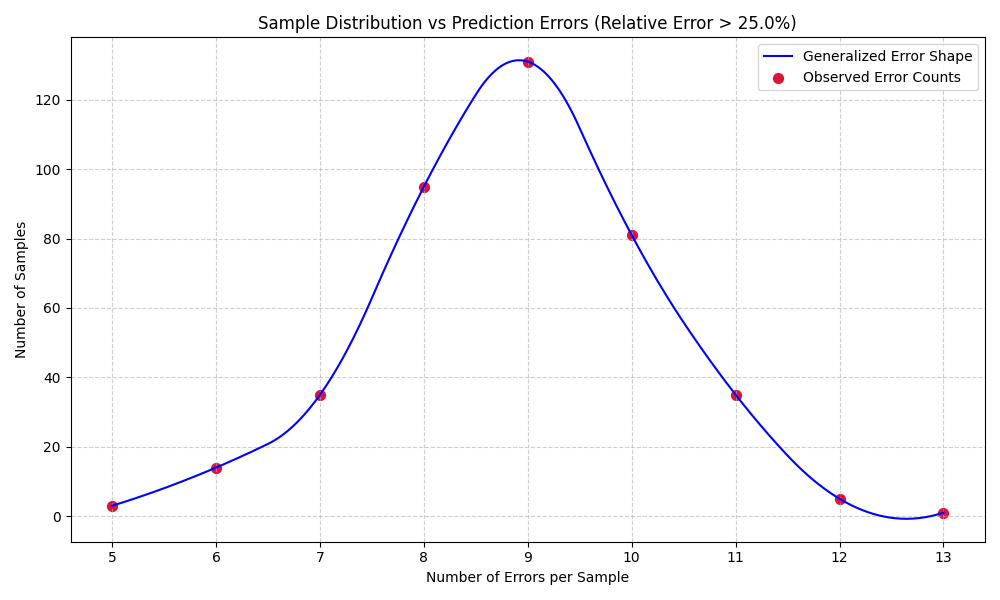

### Evaluating: BB-75Epochs-0d0001LearningRate-128LSTM_Units-0d25DropoutRate ###


## **📈 BB-75Epochs-0d0001LearningRate-128LSTM_Units-0d25DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 128
- **Dropout Rate** : 0.25
- **Learning Rate** : 0.0001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029960905
- **Root Mean Squared Error (RMSE)**  : 0.173092186
- **Mean Absolute Error (MAE)**       : 0.041214181

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155793386
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394706709
- **Weighted Mean Absolute Error (MAE)**       : 0.211966198

    

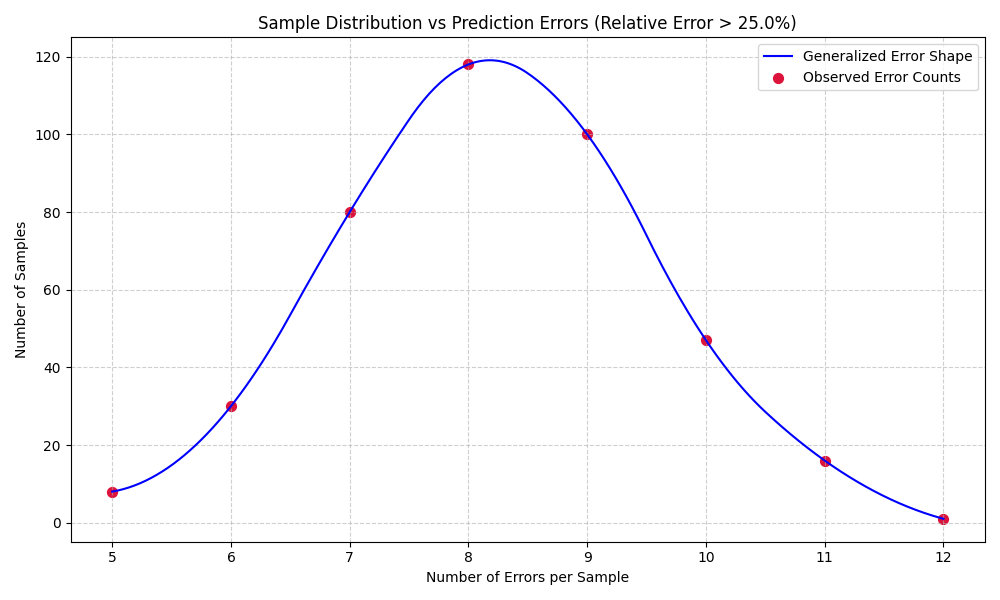

### Evaluating: BB-75Epochs-0d0001LearningRate-128LSTM_Units-0d35DropoutRate ###


## **📈 BB-75Epochs-0d0001LearningRate-128LSTM_Units-0d35DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 128
- **Dropout Rate** : 0.35
- **Learning Rate** : 0.0001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029932120
- **Root Mean Squared Error (RMSE)**  : 0.173009018
- **Mean Absolute Error (MAE)**       : 0.040529034

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155643867
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394517258
- **Weighted Mean Absolute Error (MAE)**       : 0.207983336

    

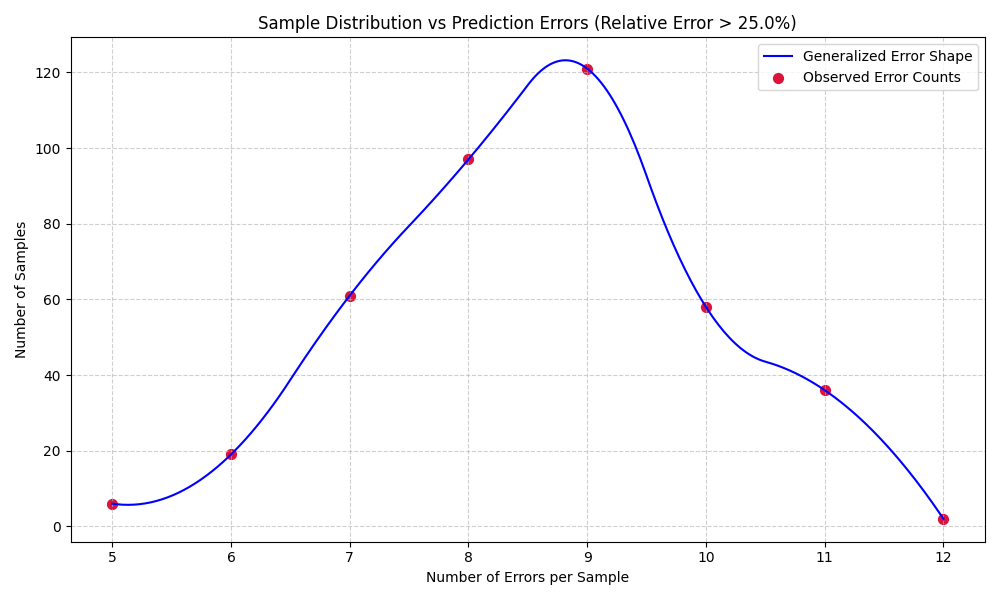

### Evaluating: BB-75Epochs-0d0001LearningRate-64LSTM_Units-0d1DropoutRate ###


## **📈 BB-75Epochs-0d0001LearningRate-64LSTM_Units-0d1DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 64
- **Dropout Rate** : 0.1
- **Learning Rate** : 0.0001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029927736
- **Root Mean Squared Error (RMSE)**  : 0.172996346
- **Mean Absolute Error (MAE)**       : 0.040875068

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155622789
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394490544
- **Weighted Mean Absolute Error (MAE)**       : 0.211516765

    

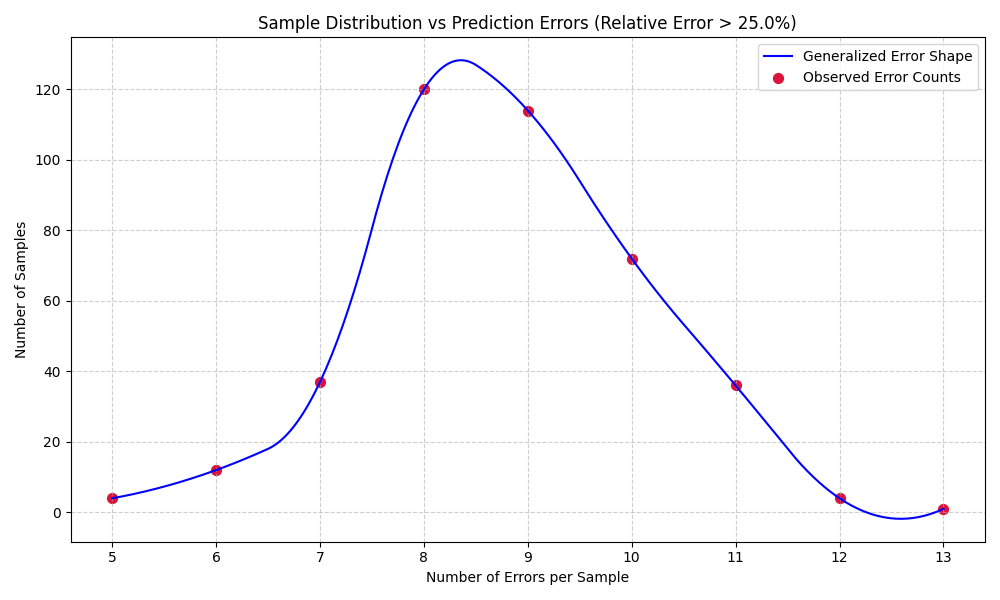

### Evaluating: BB-75Epochs-0d0001LearningRate-64LSTM_Units-0d25DropoutRate ###


## **📈 BB-75Epochs-0d0001LearningRate-64LSTM_Units-0d25DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 64
- **Dropout Rate** : 0.25
- **Learning Rate** : 0.0001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029917859
- **Root Mean Squared Error (RMSE)**  : 0.172967798
- **Mean Absolute Error (MAE)**       : 0.039796821

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155572745
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394427110
- **Weighted Mean Absolute Error (MAE)**       : 0.206443219

    

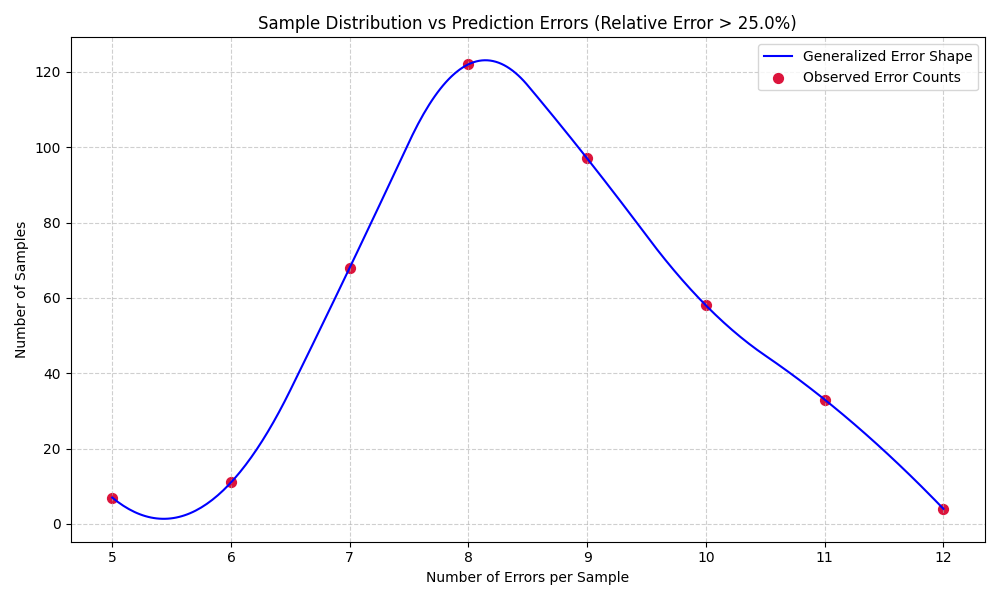

### Evaluating: BB-75Epochs-0d0001LearningRate-64LSTM_Units-0d35DropoutRate ###


## **📈 BB-75Epochs-0d0001LearningRate-64LSTM_Units-0d35DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 64
- **Dropout Rate** : 0.35
- **Learning Rate** : 0.0001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029881426
- **Root Mean Squared Error (RMSE)**  : 0.172862449
- **Mean Absolute Error (MAE)**       : 0.040684369

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155381637
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394184775
- **Weighted Mean Absolute Error (MAE)**       : 0.209426983

    

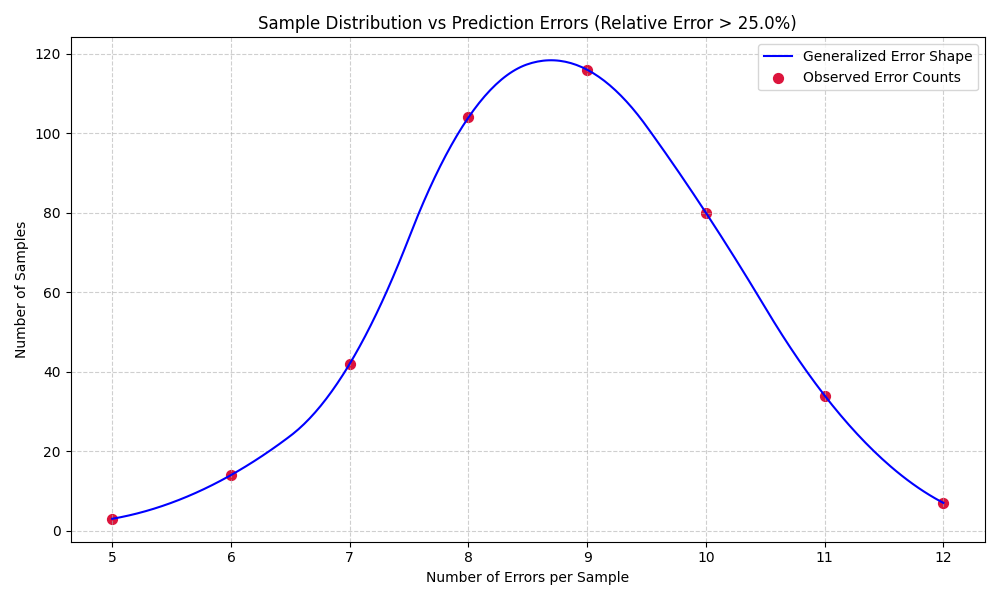

### Evaluating: BB-75Epochs-0d0005LearningRate-128LSTM_Units-0d1DropoutRate ###


## **📈 BB-75Epochs-0d0005LearningRate-128LSTM_Units-0d1DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 128
- **Dropout Rate** : 0.1
- **Learning Rate** : 0.0005

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029934209
- **Root Mean Squared Error (RMSE)**  : 0.173015055
- **Mean Absolute Error (MAE)**       : 0.039964428

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155657889
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394535029
- **Weighted Mean Absolute Error (MAE)**       : 0.207809581

    

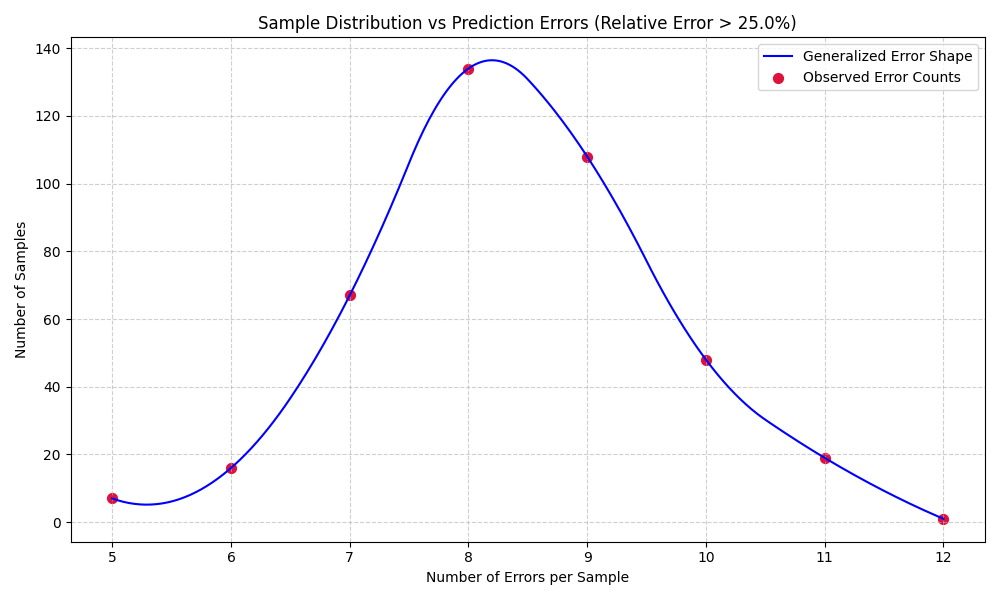

### Evaluating: BB-75Epochs-0d0005LearningRate-128LSTM_Units-0d25DropoutRate ###


## **📈 BB-75Epochs-0d0005LearningRate-128LSTM_Units-0d25DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 128
- **Dropout Rate** : 0.25
- **Learning Rate** : 0.0005

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029943695
- **Root Mean Squared Error (RMSE)**  : 0.173042465
- **Mean Absolute Error (MAE)**       : 0.039925152

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155707213
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394597533
- **Weighted Mean Absolute Error (MAE)**       : 0.207606848

    

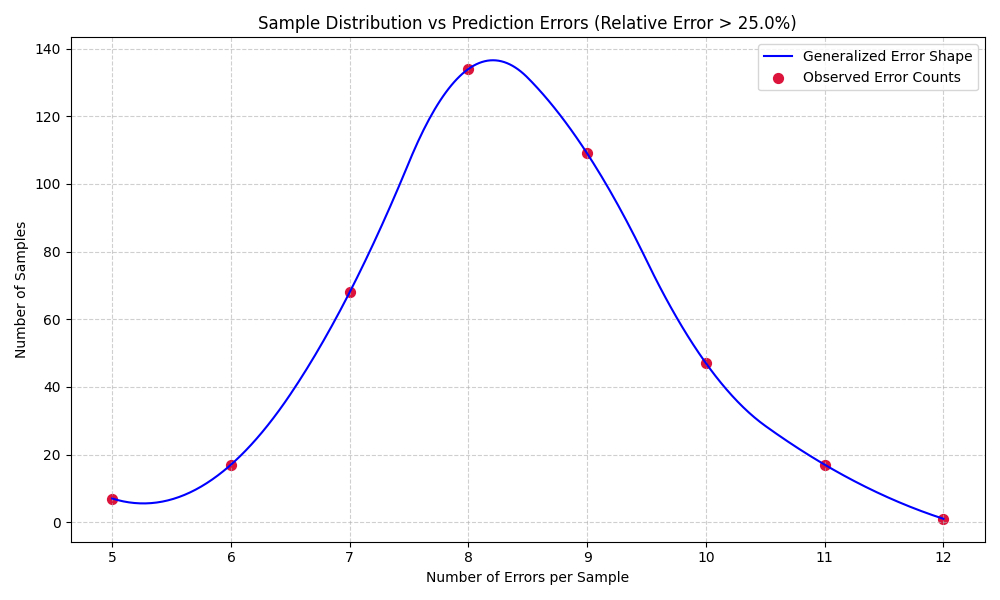

### Evaluating: BB-75Epochs-0d0005LearningRate-128LSTM_Units-0d35DropoutRate ###


## **📈 BB-75Epochs-0d0005LearningRate-128LSTM_Units-0d35DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 128
- **Dropout Rate** : 0.35
- **Learning Rate** : 0.0005

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029942465
- **Root Mean Squared Error (RMSE)**  : 0.173038913
- **Mean Absolute Error (MAE)**       : 0.040077009

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155700820
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394589433
- **Weighted Mean Absolute Error (MAE)**       : 0.208394836

    

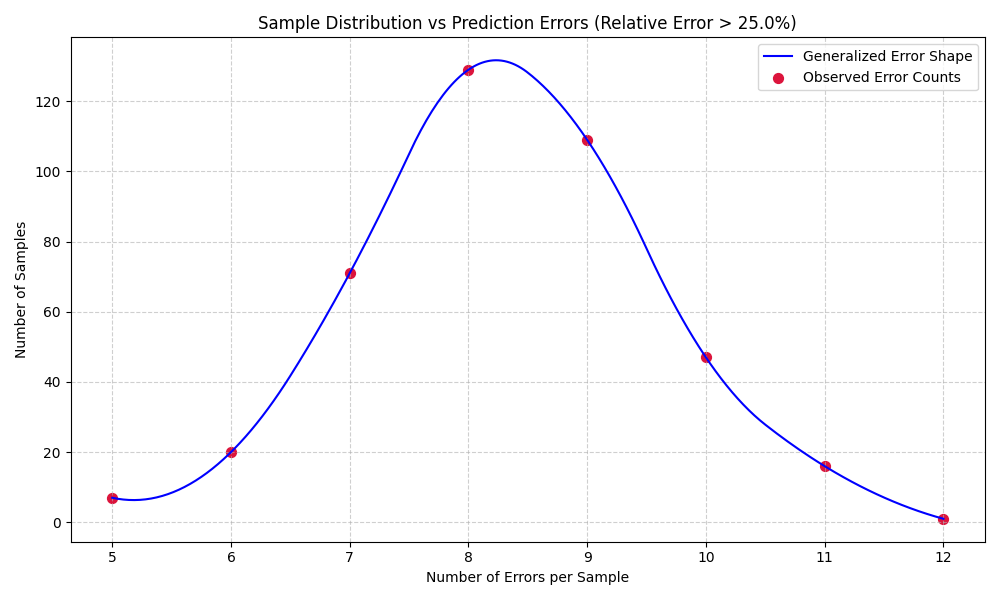

### Evaluating: BB-75Epochs-0d0005LearningRate-64LSTM_Units-0d1DropoutRate ###


## **📈 BB-75Epochs-0d0005LearningRate-64LSTM_Units-0d1DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 64
- **Dropout Rate** : 0.1
- **Learning Rate** : 0.0005

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029929377
- **Root Mean Squared Error (RMSE)**  : 0.173001090
- **Mean Absolute Error (MAE)**       : 0.040110277

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155632761
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394503182
- **Weighted Mean Absolute Error (MAE)**       : 0.208564536

    

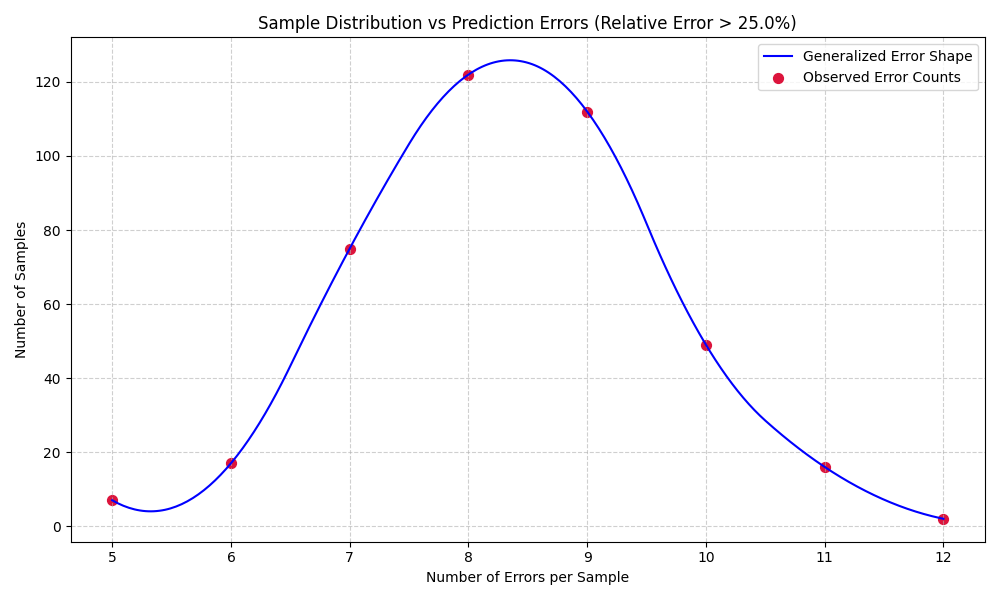

### Evaluating: BB-75Epochs-0d0005LearningRate-64LSTM_Units-0d25DropoutRate ###


## **📈 BB-75Epochs-0d0005LearningRate-64LSTM_Units-0d25DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 64
- **Dropout Rate** : 0.25
- **Learning Rate** : 0.0005

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029935181
- **Root Mean Squared Error (RMSE)**  : 0.173017864
- **Mean Absolute Error (MAE)**       : 0.039835661

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155662943
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394541433
- **Weighted Mean Absolute Error (MAE)**       : 0.207143574

    

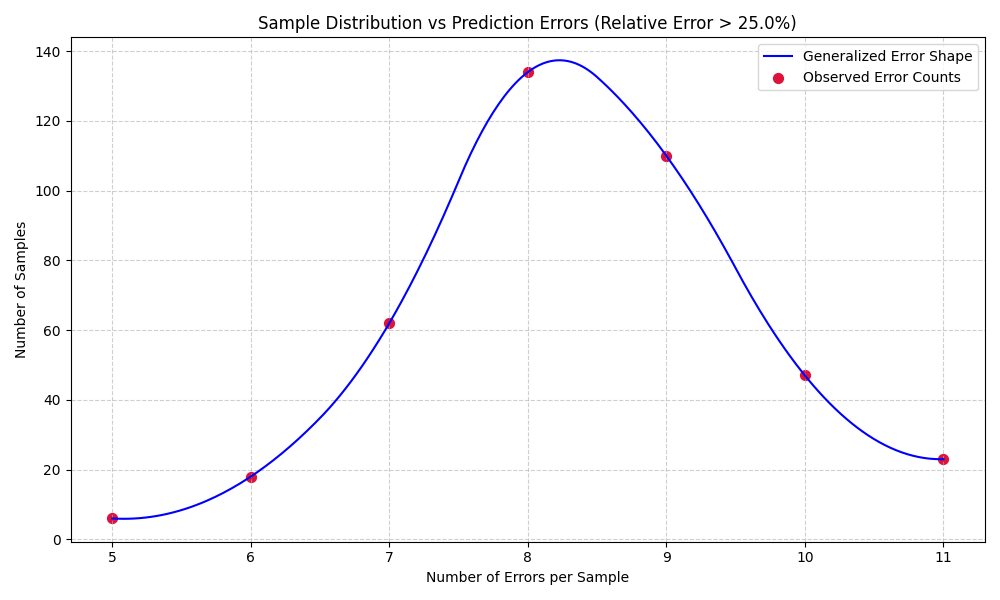

### Evaluating: BB-75Epochs-0d0005LearningRate-64LSTM_Units-0d35DropoutRate ###


## **📈 BB-75Epochs-0d0005LearningRate-64LSTM_Units-0d35DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 64
- **Dropout Rate** : 0.35
- **Learning Rate** : 0.0005

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029933042
- **Root Mean Squared Error (RMSE)**  : 0.173011681
- **Mean Absolute Error (MAE)**       : 0.039977229

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155651817
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394527334
- **Weighted Mean Absolute Error (MAE)**       : 0.207870785

    

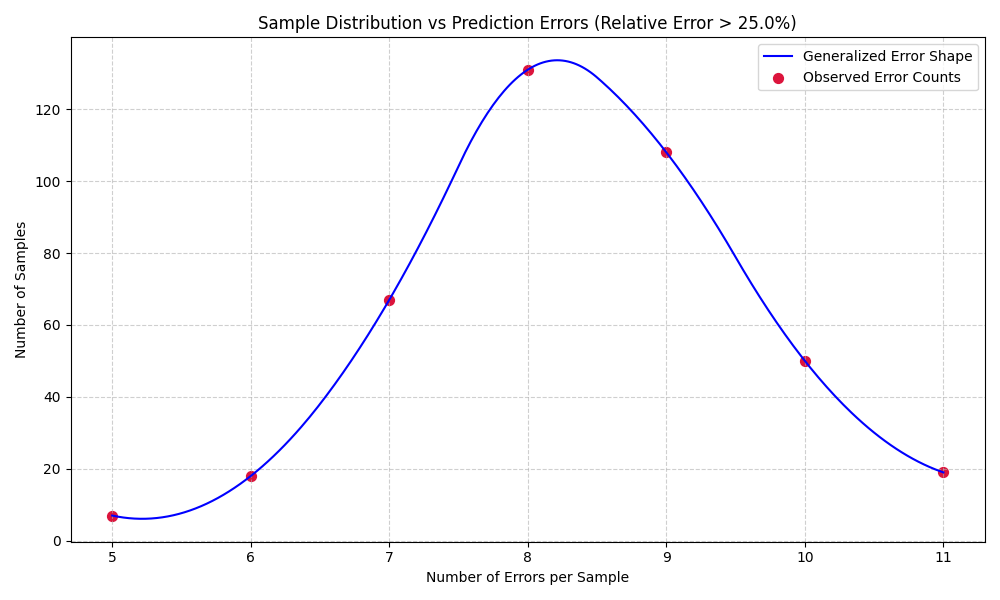

### Evaluating: BB-75Epochs-0d001LearningRate-128LSTM_Units-0d1DropoutRate ###


## **📈 BB-75Epochs-0d001LearningRate-128LSTM_Units-0d1DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 128
- **Dropout Rate** : 0.1
- **Learning Rate** : 0.001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029922261
- **Root Mean Squared Error (RMSE)**  : 0.172980521
- **Mean Absolute Error (MAE)**       : 0.040172029

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155595752
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394456274
- **Weighted Mean Absolute Error (MAE)**       : 0.208863857

    

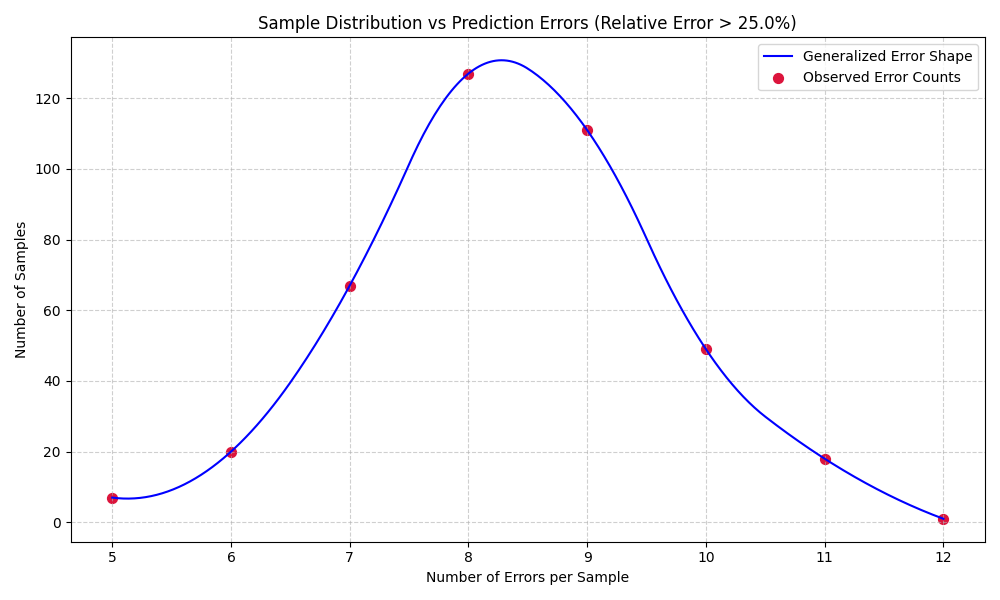

### Evaluating: BB-75Epochs-0d001LearningRate-128LSTM_Units-0d25DropoutRate ###


## **📈 BB-75Epochs-0d001LearningRate-128LSTM_Units-0d25DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 128
- **Dropout Rate** : 0.25
- **Learning Rate** : 0.001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029934206
- **Root Mean Squared Error (RMSE)**  : 0.173015045
- **Mean Absolute Error (MAE)**       : 0.040023398

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155657871
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394535006
- **Weighted Mean Absolute Error (MAE)**       : 0.208121669

    

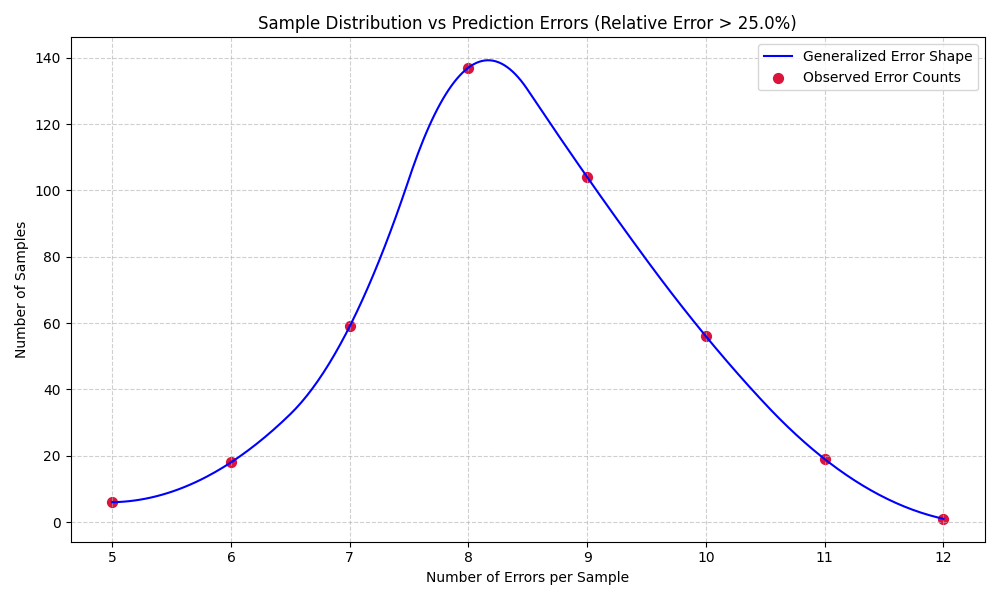

### Evaluating: BB-75Epochs-0d001LearningRate-128LSTM_Units-0d35DropoutRate ###


## **📈 BB-75Epochs-0d001LearningRate-128LSTM_Units-0d35DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 128
- **Dropout Rate** : 0.35
- **Learning Rate** : 0.001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029928505
- **Root Mean Squared Error (RMSE)**  : 0.172998568
- **Mean Absolute Error (MAE)**       : 0.039950900

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155628223
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394497431
- **Weighted Mean Absolute Error (MAE)**       : 0.207730296

    

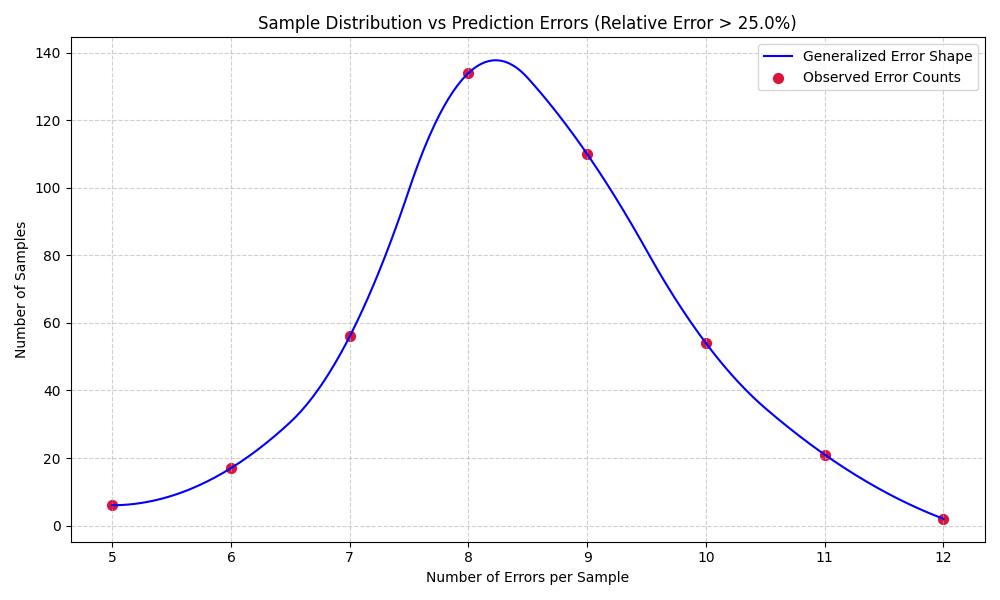

### Evaluating: BB-75Epochs-0d001LearningRate-64LSTM_Units-0d1DropoutRate ###


## **📈 BB-75Epochs-0d001LearningRate-64LSTM_Units-0d1DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 64
- **Dropout Rate** : 0.1
- **Learning Rate** : 0.001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029934682
- **Root Mean Squared Error (RMSE)**  : 0.173016421
- **Mean Absolute Error (MAE)**       : 0.039763024

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155660345
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394538141
- **Weighted Mean Absolute Error (MAE)**       : 0.206762007

    

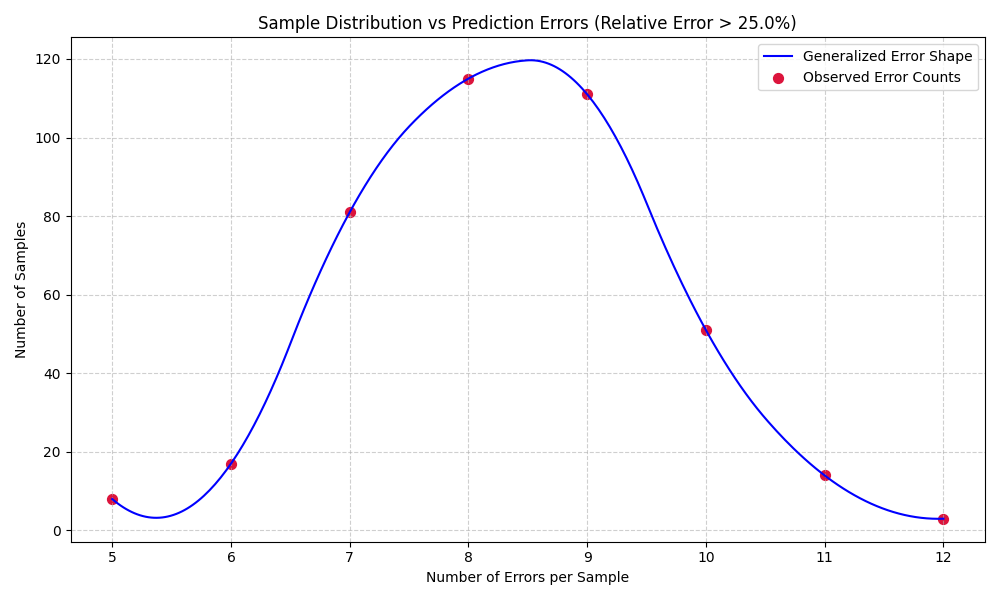

### Evaluating: BB-75Epochs-0d001LearningRate-64LSTM_Units-0d25DropoutRate ###


## **📈 BB-75Epochs-0d001LearningRate-64LSTM_Units-0d25DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 64
- **Dropout Rate** : 0.25
- **Learning Rate** : 0.001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029949240
- **Root Mean Squared Error (RMSE)**  : 0.173058489
- **Mean Absolute Error (MAE)**       : 0.039982289

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155736050
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394634071
- **Weighted Mean Absolute Error (MAE)**       : 0.207900617

    

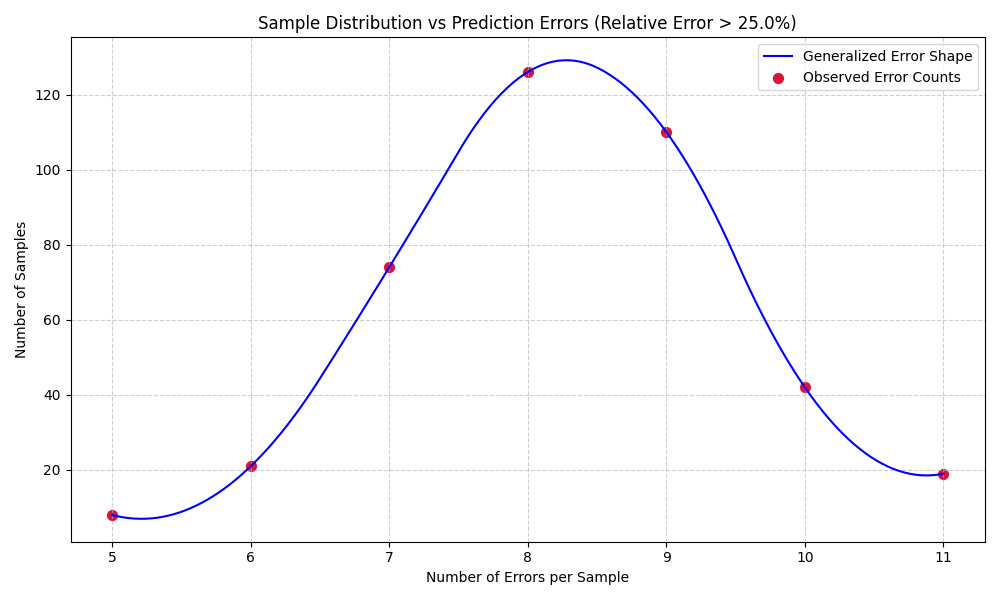

### Evaluating: BB-75Epochs-0d001LearningRate-64LSTM_Units-0d35DropoutRate ###


## **📈 BB-75Epochs-0d001LearningRate-64LSTM_Units-0d35DropoutRate
---
**# Model Performance Evaluation Report
## Hyperparameter Configuration:
- **Epochs** : 75
- **LSTM Units** : 64
- **Dropout Rate** : 0.35
- **Learning Rate** : 0.001

## Unweighted Metrics
- **Mean Squared Error (MSE)**        : 0.029923125
- **Root Mean Squared Error (RMSE)**  : 0.172983019
- **Mean Absolute Error (MAE)**       : 0.040130216

## Weighted Metrics
- **Weighted Mean Squared Error (MSE)**        : 0.155600248
- **Weighted Root Mean Squared Error (RMSE)**  : 0.394461973
- **Weighted Mean Absolute Error (MAE)**       : 0.208670610

    

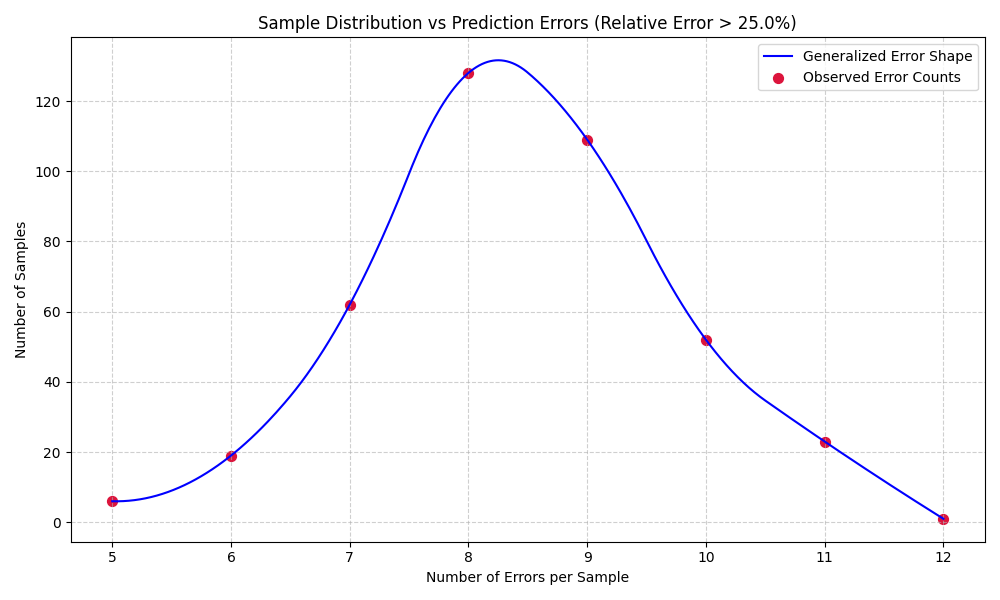

In [ ]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown, Image

prefix = "models/"
filter_prefix = "BB-75Epochs"

s3 = boto3.client("s3")

# 1. List all folders starting with "BB-75Epochs"
response = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=prefix)
keys = [obj['Key'] for obj in response.get("Contents", []) if filter_prefix in obj['Key']]

# 2. Extract folder names
folders = sorted(set(k.split('/')[1] for k in keys if k.endswith("model_evaluation.md")))

# 3. Display each pair side-by-side
for folder in folders:
    print(f"### Evaluating: {folder} ###")
    
    # Model Evaluation .md
    md_key = f"{prefix}{folder}/model_evaluation.md"
    md_obj = s3.get_object(Bucket=BUCKET_NAME, Key=md_key)
    md_text = md_obj['Body'].read().decode("utf-8")
    
    # Error Distribution Plot
    plot_key = f"{prefix}{folder}/relative-error-distribution.png"
    plot_obj = s3.get_object(Bucket=BUCKET_NAME, Key=plot_key)
    plot_bytes = plot_obj['Body'].read()
    
    # Display side by side (image + markdown)
    display(Markdown(f"##{folder}\n---\n" + md_text))
    display(Image(data=plot_bytes))